# Predicción de Series Temporales con Redes Neuronales

## Usaremos Keras y Tensorflow

Usaremos una arquitectura sencilla de red neuronal FeedForward (también llamada MLP por sus siglas Multi-Layered Perceptron), con pocas neuronas y como método de activación tangente hiperbólica pues entregaremos valores transformados entre -1 y 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
import datetime

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
 

Using TensorFlow backend.


### Cargamos nuestro Dataset

In [2]:
df = pd.read_csv('Prueba_Unidades.csv', parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2018-04-04,118
2018-04-05,33
2018-04-06,67
2018-04-07,228
2018-04-08,200


In [3]:
print(df.index.min())
print(df.index.max())

2018-04-04 00:00:00
2019-06-21 00:00:00


In [4]:
print(len(df['2018']))
print(len(df['2019']))

241
170


In [5]:
df.describe()

,unidades
count,411.000000
mean,1215.442822
std,2411.684449
min,1.000000
25%,170.500000
50%,490.000000
75%,1175.000000
max,16614.000000


In [6]:
meses =df.resample('M').mean()
meses

,unidades
fecha,
2018-04-30,239.777778
2018-05-31,3063.375000
2018-06-30,783.800000
2018-07-31,768.703704
2018-08-31,1054.962963
2018-09-30,722.000000
2018-10-31,1945.517241
2018-11-30,1530.148148
2018-12-31,918.206897


## Visualizaciones

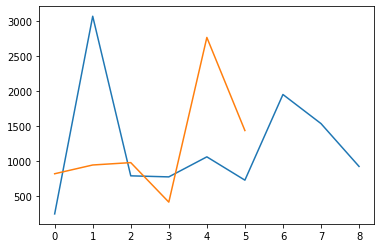

In [7]:
plt.plot(meses['2018'].values) # en azul
plt.plot(meses['2019'].values) # en naranja

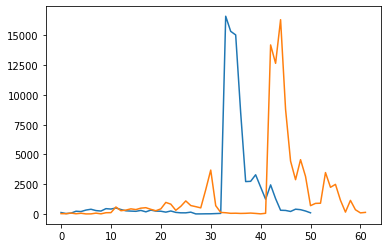

In [8]:
ver_2018 = df['2018-04-01':'2018-06-01']  # en azul
plt.plot(ver_2018.values)
ver_2019 = df['2019-04-01':'2019-06-01'] # en naranja
plt.plot(ver_2019.values)

## Preprocesado de los datos

### Pronóstico de unidades Diarias con Redes Neuronal

Lo que haremos es tomar nuestra serie temporal y la convertiremos en un «problema de tipo supervisado« para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation

In [9]:
# Lo que haremos -en este ejemplo- es tomar los 7 días previos para «obtener» el octavo
# Entradas: serán «7 columnas» que representan las unidades en unidades de los 7 días anteriores.
# Salida: El valor del «8vo día». Es decir, las unidades (en unidades) de ese día

In [10]:
# utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1
PASOS=7
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.985915,-0.996148,-0.992054,-0.972672,-0.976043,-0.960874,-0.952688,-0.966051
8,-0.996148,-0.992054,-0.972672,-0.976043,-0.960874,-0.952688,-0.966051,-0.970866
9,-0.992054,-0.972672,-0.976043,-0.960874,-0.952688,-0.966051,-0.970866,-0.946668
10,-0.972672,-0.976043,-0.960874,-0.952688,-0.966051,-0.970866,-0.946668,-0.950641
11,-0.976043,-0.960874,-0.952688,-0.966051,-0.970866,-0.946668,-0.950641,-0.939686


In [11]:
# Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida
# (lo que sería el valor «Y» de la función) será el var1(t) -la última columna-

# Creamos la Red Neuronal Artificial

## Dividimos en set de Entrenamiento y Validación
Antes de crear la red neuronal, subdividiremos nuestro conjunto de datos en train y en validación. ATENCIÓN, algo importante de este procedimiento, a diferencia de en otros problemas en los que podemos «mezclar» los datos de entrada, es que en este caso nos importa mantener el orden en el que alimentaremos la red. Por lo tanto, haremos una subdivisión de los primeros 567 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación.

In [12]:
# split into train and test sets
values = reframed.values
n_train_days = 402 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(365, 1, 7) (365,) (39, 1, 7) (39,)


## Utilizaremos una Red "normal" Feedforward

#### La arquitectura de la red neuronal será:

Entrada 7 inputs, como dijimos antes
1 capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
La salida será 1 sola neurona
Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [13]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

   ## Entrenamiento y Resultados

In [14]:
# En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación. 
# original EPOCHS = 40, luego voy modificando
EPOCHS=40
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

W0826 01:21:38.413880  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 01:21:38.543277  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 01:21:38.559278  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 01:21:38.863293  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


W0826 01:21:39.807447  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 01:21:40.384493  9876 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 365 samples, validate on 39 samples
Epoch 1/40
365/365 [==============================] - 4s 11ms/step - loss: 0.6059 - mean_squared_error: 0.4507 - val_loss: 0.3509 - val_mean_squared_error: 0.2428
Epoch 2/40
365/365 [==============================] - 0s 591us/step - loss: 0.2022 - mean_squared_error: 0.0992 - val_loss: 0.2715 - val_mean_squared_error: 0.2176
Epoch 3/40
365/365 [==============================] - 0s 762us/step - loss: 0.1355 - mean_squared_error: 0.0829 - val_loss: 0.2725 - val_mean_squared_error: 0.2196
Epoch 4/40
365/365 [==============================] - 1s 1ms/step - loss: 0.1234 - mean_squared_error: 0.0825 - val_loss: 0.2729 - val_mean_squared_error: 0.2172
Epoch 5/40
365/365 [==============================] - 0s 803us/step - loss: 0.1197 - mean_squared_error: 0.0820 - val_loss: 0.2716 - val_mean_squared_error: 0.2143
Epoch 6/40
365/365 [==============================] - 0s 716us/step - loss: 0.1179 - mean_squared_error: 0.0817 - val_loss: 0.2698 - val_m

In [15]:
# Visualizamos al conjunto de validación (recordemos que eran 30 días)

## Visualizamos Resultados

39


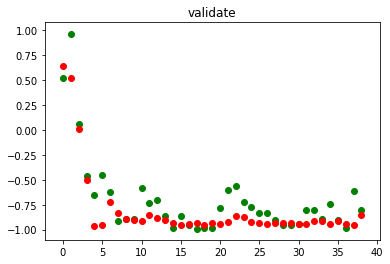

In [16]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.

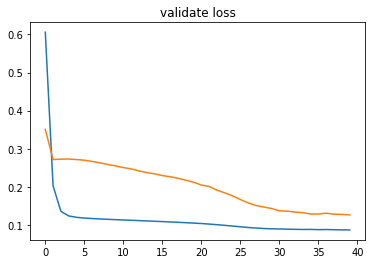

In [17]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Modelo 1) ST1: En azul el Entrenamiento y naranja el set de Validación.

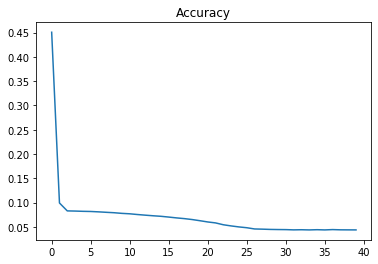

In [18]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [19]:
# En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. 
# TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.

In [20]:
# Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno
# ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate
# son distintas.

In [21]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,12657.000000,13628.933594,-971.933594
1,16324.000000,12598.520508,3725.479492
2,8789.000000,8382.088867,406.911133
3,4442.000000,4118.960938,323.039062
4,2878.999756,271.871613,2607.128174


In [22]:
compara2.describe()

,real,prediccion,diferencia
count,39.000000,39.000000,39.000000
mean,2472.461426,1627.969604,844.492065
std,3315.075195,3039.557129,1237.449097
min,88.999756,271.871613,-971.933594
25%,742.500061,498.548218,-75.519760
50%,1612.999878,630.919983,437.450439
75%,3016.000000,993.318024,1296.430786
max,16324.000000,13628.933594,4212.422852


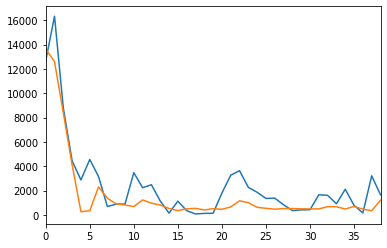

In [23]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Predicción

## Pronóstico de unidades futuras
Ahora que tenemos nuestra red y -suponiendo que realizamos los 7 pasos del ML– la damos por buena, probaremos a realizar una nueva predicción, en este caso, usaremos los últimos días de Mayo 2019 para calcular la primer semana de Junio. Veamos:

In [24]:
ultimosDias = df['2019-05-16':'2019-05-31']
ultimosDias

,unidades
fecha,
2019-05-16,8789
2019-05-17,4442
2019-05-18,2879
2019-05-19,4560
2019-05-20,3153
2019-05-21,696
2019-05-22,888
2019-05-23,900
2019-05-24,3477


## Preparamos los datos para Test

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida «Y» pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [25]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,1.000000,0.000690,-0.358621,0.027816,-0.295632,-0.860460,-0.816322
8,0.000690,-0.358621,0.027816,-0.295632,-0.860460,-0.816322,-0.813563
9,-0.358621,0.027816,-0.295632,-0.860460,-0.816322,-0.813563,-0.221149
10,0.027816,-0.295632,-0.860460,-0.816322,-0.813563,-0.221149,-0.505747
11,-0.295632,-0.860460,-0.816322,-0.813563,-0.221149,-0.505747,-0.448965
12,-0.860460,-0.816322,-0.813563,-0.221149,-0.505747,-0.448965,-0.756092
13,-0.816322,-0.813563,-0.221149,-0.505747,-0.448965,-0.756092,-0.985057


De este conjunto «ultimosDias» tomamos sólo la última fila, pues es la que correspondería a la última semana de Mayo y la dejamos en el formato correcto para la red neuronal con reshape:

In [26]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-0.81632185, -0.8135632 , -0.22114944, -0.50574714,
         -0.4489655 , -0.75609195, -0.9850575 ]],

       [[-0.8135632 , -0.22114944, -0.50574714, -0.4489655 ,
         -0.75609195, -0.9850575 , -0.7586207 ]],

       [[-0.22114944, -0.50574714, -0.4489655 , -0.75609195,
         -0.9850575 , -0.7586207 , -0.9393103 ]]], dtype=float32)

Ahora crearemos una función para ir «rellenando» el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de Junio. Entonces para el 1 de Junio, ya tenemos el set con los últimos 7 días de Mayo. Pero para pronosticar el 2 de Junio necesitamos los 7 días anteriores que INCLUYEN al 1 de Junio y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de Junio.

In [27]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test
 

## Pronóstico para la "próxima semana"

In [28]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.81632185 -0.8135632  -0.22114944 -0.50574714 -0.4489655
   -0.75609195 -0.9850575 ]]

 [[-0.8135632  -0.22114944 -0.50574714 -0.4489655  -0.75609195
   -0.9850575  -0.7586207 ]]

 [[-0.22114944 -0.50574714 -0.4489655  -0.75609195 -0.9850575
   -0.7586207  -0.9393103 ]]]
[[[-0.8135632  -0.22114944 -0.50574714 -0.4489655  -0.75609195
   -0.9850575  -0.9643803 ]]

 [[-0.8135632  -0.22114944 -0.50574714 -0.4489655  -0.75609195
   -0.9850575  -0.7586207 ]]

 [[-0.22114944 -0.50574714 -0.4489655  -0.75609195 -0.9850575
   -0.7586207  -0.9393103 ]]]
[[[-0.22114944 -0.50574714 -0.4489655  -0.75609195 -0.9850575
   -0.9643803  -0.95667493]]

 [[-0.8135632  -0.22114944 -0.50574714 -0.4489655  -0.75609195
   -0.9850575  -0.7586207 ]]

 [[-0.22114944 -0.50574714 -0.4489655  -0.75609195 -0.9850575
   -0.7586207  -0.9393103 ]]]
[[[-0.50574714 -0.4489655  -0.75609195 -0.9850575  -0.9643803
   -0.95667493 -0.9168126 ]]

 [[-0.8135632  -0.22114944 -0.50574714 -0.4489655  -0.75609195
   -0.9850575

## Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala «real» de unidades vendidas. Entonces vamos a «re-transformar» los datos con el objeto «scaler» que creamos antes.

In [29]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[243.94559344],
       [277.46404161],
       [450.86519613],
       [384.91286888],
       [435.50310342],
       [386.58730042],
       [331.67667987]])

## Visualizamos el pronóstico

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

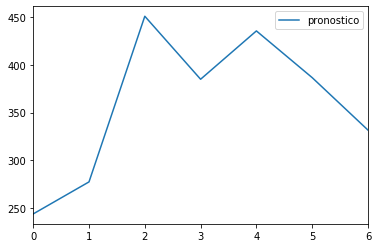

In [30]:
prediccion1SemanaJunio = pd.DataFrame(inverted)
prediccion1SemanaJunio.columns = ['pronostico']
prediccion1SemanaJunio.plot()
prediccion1SemanaJunio.to_csv('pronostico_simple_U.csv')

In [31]:
prediccion1SemanaJunio

,pronostico
0,243.945593
1,277.464042
2,450.865196
3,384.912869
4,435.503103
5,386.587300
6,331.676680


A partir de los últimos 7 días de Mayo 2019 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de unidades para la primer semana de Junio.

Para Probar, alterando parámetros del ejercicio:

Variar la cantidad de EPOCHS Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate. Cambiar la arquitectura de la Red Neuronal: Cambiar la cantidad de Neuronas de la capa oculta. Agregar más capas ocultas Probar utilizando más de 7 días previos para predecir. O probar con menos días. Se puede intentar predecir más de 1 día por vez (sin iterar el resultado como hice con la función agregarNuevoValor() )

## Agregamos el resultado en el dataset

In [32]:
i=0
for fila in prediccion1SemanaJunio.pronostico:
    i=i+1
    ultimosDias.loc['2019-06-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

243.94559344243908
277.4640416149789
450.8651961335093
384.9128688753044
435.5031034181752
386.58730042276727
331.6766798663669


C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,unidades
fecha,
2019-05-25 00:00:00,2239.000000
2019-05-26 00:00:00,2486.000000
2019-05-27 00:00:00,1150.000000
2019-05-28 00:00:00,154.000000
2019-05-29 00:00:00,1139.000000
2019-05-30 00:00:00,353.000000
2019-05-31 00:00:00,89.000000
2019-06-01 00:00:00,243.945593
2019-06-02 00:00:00,277.464042
